# Analytical solution for streamflow recession

In [1]:

# Filter warnings (before imports)
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

import pkg_resources # Must be placed after DeprecationWarning as it is itself deprecated
warnings.filterwarnings('ignore', message='.*pkg_resources.*')
warnings.filterwarnings('ignore', message='.*declare_namespace.*')

# Libraries installed by default
import sys
import os

# Libraries need to be installed if not
import numpy as np
import pandas as pd

# Libraries added from 'conda install' procedure
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
import rasterio
from IPython import get_ipython
get_ipython().run_line_magic('matplotlib', 'inline')
import flopy
import flopy.utils.binaryfile as fpu
import flopy.utils.binaryfile as bf
import imageio
from osgeo import gdal
import whitebox
wbt = whitebox.WhiteboxTools()
wbt.verbose = True



/home/agauvain/anaconda3/envs/hmp/lib/python3.8/site-packages/osgeo/__init__.py:8: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp


In [2]:

from os.path import dirname, abspath
root_dir = '/home/agauvain/Git/HydroModPy'
sys.path.append(root_dir)
print("Root path directory is: {0}".format(root_dir.upper()))



Root path directory is: /HOME/AGAUVAIN/GIT/HYDROMODPY


In [3]:

import src
import importlib
importlib.reload(src)

# Import HydroModPy modules
from src import watershed_root
from src.display import visualization_results, export_vtuvtk
from src.tools import toolbox, folder_root

fontprop = toolbox.plot_params(8,15,18,20) # small, medium, interm, large

def select_period(df, first, last):
    df = df[(df.index.year>=first) & (df.index.year<=last)]
    return df



In [4]:

example_path = os.path.join(root_dir, "examples", "07_analytical solution for streamflow recession/")
data_path = os.path.join(example_path, "data/")

# The folder out_path is created in the example_path root directory:
out_path = os.path.join(root_dir,'examples', 'results')
# Or define it manually
# out_path = 'C:/Simulations/HydroModPy/'

print('The results of the example will be saved here :', out_path)



The results of the example will be saved here : /home/agauvain/Git/HydroModPy/examples/results


In [5]:

case = 'Example_07_Hillslope'

if case == 'Example_07_Hillslope':
    dem_path_ref = data_path + 'hillslope_1D.tif'
    
    resamp_res = 20
    dem_path_res = data_path + 'hillslope_1D_resampled'+str(resamp_res)+'.tif'
    
    if not os.path.exists(dem_path_res):
        # open reference file and get resolution
        x_res = resamp_res
        y_res = resamp_res  # make sure this value is positive
        # specify input and output filenames
        inputFile = dem_path_ref
        outputFile = dem_path_res
        # call gdal Warp
        kwargs = {"format": "GTiff", "xRes": x_res, "yRes": y_res}
        ds = gdal.Warp(outputFile, inputFile, **kwargs)
        del(ds)
        
    x = imageio.imread(dem_path_res)
    x = (x*0)+100
    toolbox.export_tif(dem_path_res, x, data_path + 'hillslope_1D_userdefined.tif', -99999)
    dem_path = data_path + 'hillslope_1D_userdefined.tif'
    
    load = False
    watershed_name = case
    from_lib = None # os.path.join(root_dir,'watershed_library.csv')
    from_dem = [dem_path, 10] # [path, cell size]
    from_shp = None # [path, buffer size]
    from_xyv = None # [x, y, snap distance, buffer size]
    bottom_path = None # path
    modflow_path = os.path.join(root_dir,'bin/')
    save_object = True



In [6]:

print('##### '+watershed_name.upper()+' #####')

# load = True
BV = watershed_root.Watershed(dem_path=dem_path,
                              out_path=out_path,
                              load=load,
                              watershed_name=watershed_name,
                              from_lib=from_lib, # os.path.join(root_dir,'watershed_library.csv')
                              from_dem=from_dem, # [path, cell size]
                              from_shp=from_shp, # [path, buffer size]
                              from_xyv=from_xyv, # [x, y, snap distance, buffer size]
                              bottom_path=bottom_path, # path 
                              save_object=save_object)

# Paths generated automatically but necessary for plots
stable_folder = out_path+'/'+watershed_name+'/'+'results_stable/'
simulations_folder = out_path+'/'+watershed_name+'/'+'results_simulations/'



##### EXAMPLE_07_HILLSLOPE #####
      __  __          __           __  ____          ________     
     / / / /         / /          /  \/   /         / / __  /     
    / /_/ /_  ______/ /________  /       /___  ____/ / /_/ /_  __ 
   / __  / / / / __  / ___/ __ \/ /\,-/ / __ \/ __  / ____/ / / / 
  / / / / /_/ / /_/ / /  / /_/ / /   / / /_/ / /_/ / /   / /_/ /  
 /_/ /_/\__, /_____/_/   \____/_/   /_/\____/_____/_/____\__, /   
       /____/ Hydrological Modelling in Python /_____________/    
                                                                  
Python object was not loaded as requested; it was created from scratch
Extract geography of the model area


In [7]:

# # Necessary to set model parameters
BV.add_climatic()

x = pd.read_csv(data_path+'/'+'_REC_D.csv', sep=';', parse_dates=True, index_col=0)
x = x.sort_index()
x = select_period(x, 2001, 2003)
x = x['REA_historic'] / 1000
Rd = x.copy()
Rw = x.resample('W').mean()
Rm = x.resample('M').mean()
y = pd.read_csv(data_path+'/'+'_RUN_D.csv', sep=';', parse_dates=True, index_col=0)
y = y.sort_index()
y = select_period(y, 2001, 2003)
y = y['REA_historic'] / 1000
rd = y.copy()
rw = y.resample('M').mean()
rm = y.resample('M').mean()



Init climatic module to set model parameter


In [8]:

model_name = 'default_weekly_mperday_split'

# Frame settings
box = True # or False
sink_fill = False # or True
sim_state = 'transient' # 'steady' or 'transient'
plot_cross = False
dis_perlen =  True
check_grid = True

# Ratio to reach 
KR = 10 # hydraulic conductivity divided by recharge

# Climatic settings
rval = 33 / 1000 # 33 mm/day
recharge = pd.Series(np.ones(1000)*0)
recharge[:30] = rval
first_clim = 'mean'

# Hydraulic settings
hyd_cond = KR * rval
nlay = 10
lay_decay = 1 # 1 for no decay
bottom = 0 # elevation in meters, None for constant auifer thickness, or 2D matrix
thick = 30 # if bottom is None, aquifer thickness
cond_decay = 0 # exponential decay : 1/20 (half decrease at 20m)
cond_drain = None # or value of conductance
porosity = 1 / 100 # -
ss = 1e-5

# Boundary settings
bc_left = 0 # or value
bc_right = None # or value
sea_level = 'None' # or value based on specific data : BV.oceanic.MSL

# Particle tracking settings
zone_partic = 'watershed' # domain or watershed or path
tif_file = '' # or 'path with .tif'
tracking_dir = 'forward' # backward or forward



In [9]:

# Import modules
BV.add_settings()
BV.add_climatic()
BV.add_hydraulic()

# Frame settings
BV.settings.update_model_name(model_name)
BV.settings.update_box_model(box)
BV.settings.update_sink_fill(sink_fill)
BV.settings.update_simulation_state(sim_state)
BV.settings.update_check_model(plot_cross=plot_cross, check_grid=check_grid)

# Climatic settings
BV.climatic.update_recharge(recharge, sim_state=sim_state)
BV.climatic.update_first_clim(first_clim)

# Hydraulic settings
BV.hydraulic.update_nlay(nlay) # 1
BV.hydraulic.update_lay_decay(lay_decay) # 1
BV.hydraulic.update_bottom(bottom) # None
BV.hydraulic.update_thick(thick) # 30 / intervient pas si bottom != None
BV.hydraulic.update_hk(hyd_cond)
BV.hydraulic.update_sy(porosity)
BV.hydraulic.update_cond_drain(cond_drain)
BV.hydraulic.update_ss(ss)

# Boundary settings
BV.settings.update_bc_sides(bc_left, bc_right)
BV.add_oceanic(sea_level)
BV.settings.update_dis_perlen(dis_perlen)

# Particle tracking settings
BV.settings.update_input_particles(zone_partic=BV.geographic.watershed_box_buff_dem) # or 'seepage_path'



Init settings module to set model parameter
Init climatic module to set model parameter
Init hydraulic module to set model parameter


In [10]:

model_modflow = BV.preprocessing_modflow(for_calib=False)
success_modflow = BV.processing_modflow(model_modflow, write_model=True, run_model=True)



Check model grid: all cells satisfy the water flow connectivity condition
FloPy is using the following executable to run the model: ../../../../../bin/linux/mfnwt

                                  MODFLOW-NWT-SWR1 
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUNDWATER-FLOW MODEL
                             WITH NEWTON FORMULATION
                             Version 1.3.0 07/01/2022                        
                    BASED ON MODFLOW-2005 Version 1.12.0 02/03/2017                       

                    SWR1 Version 1.05.0 03/10/2022                       

 Using NAME file: default_weekly_mperday_split.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2025/01/09 11:59:23

 Solving:  Stress period:     1    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:     3    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:     4    Time step:     1    Gro

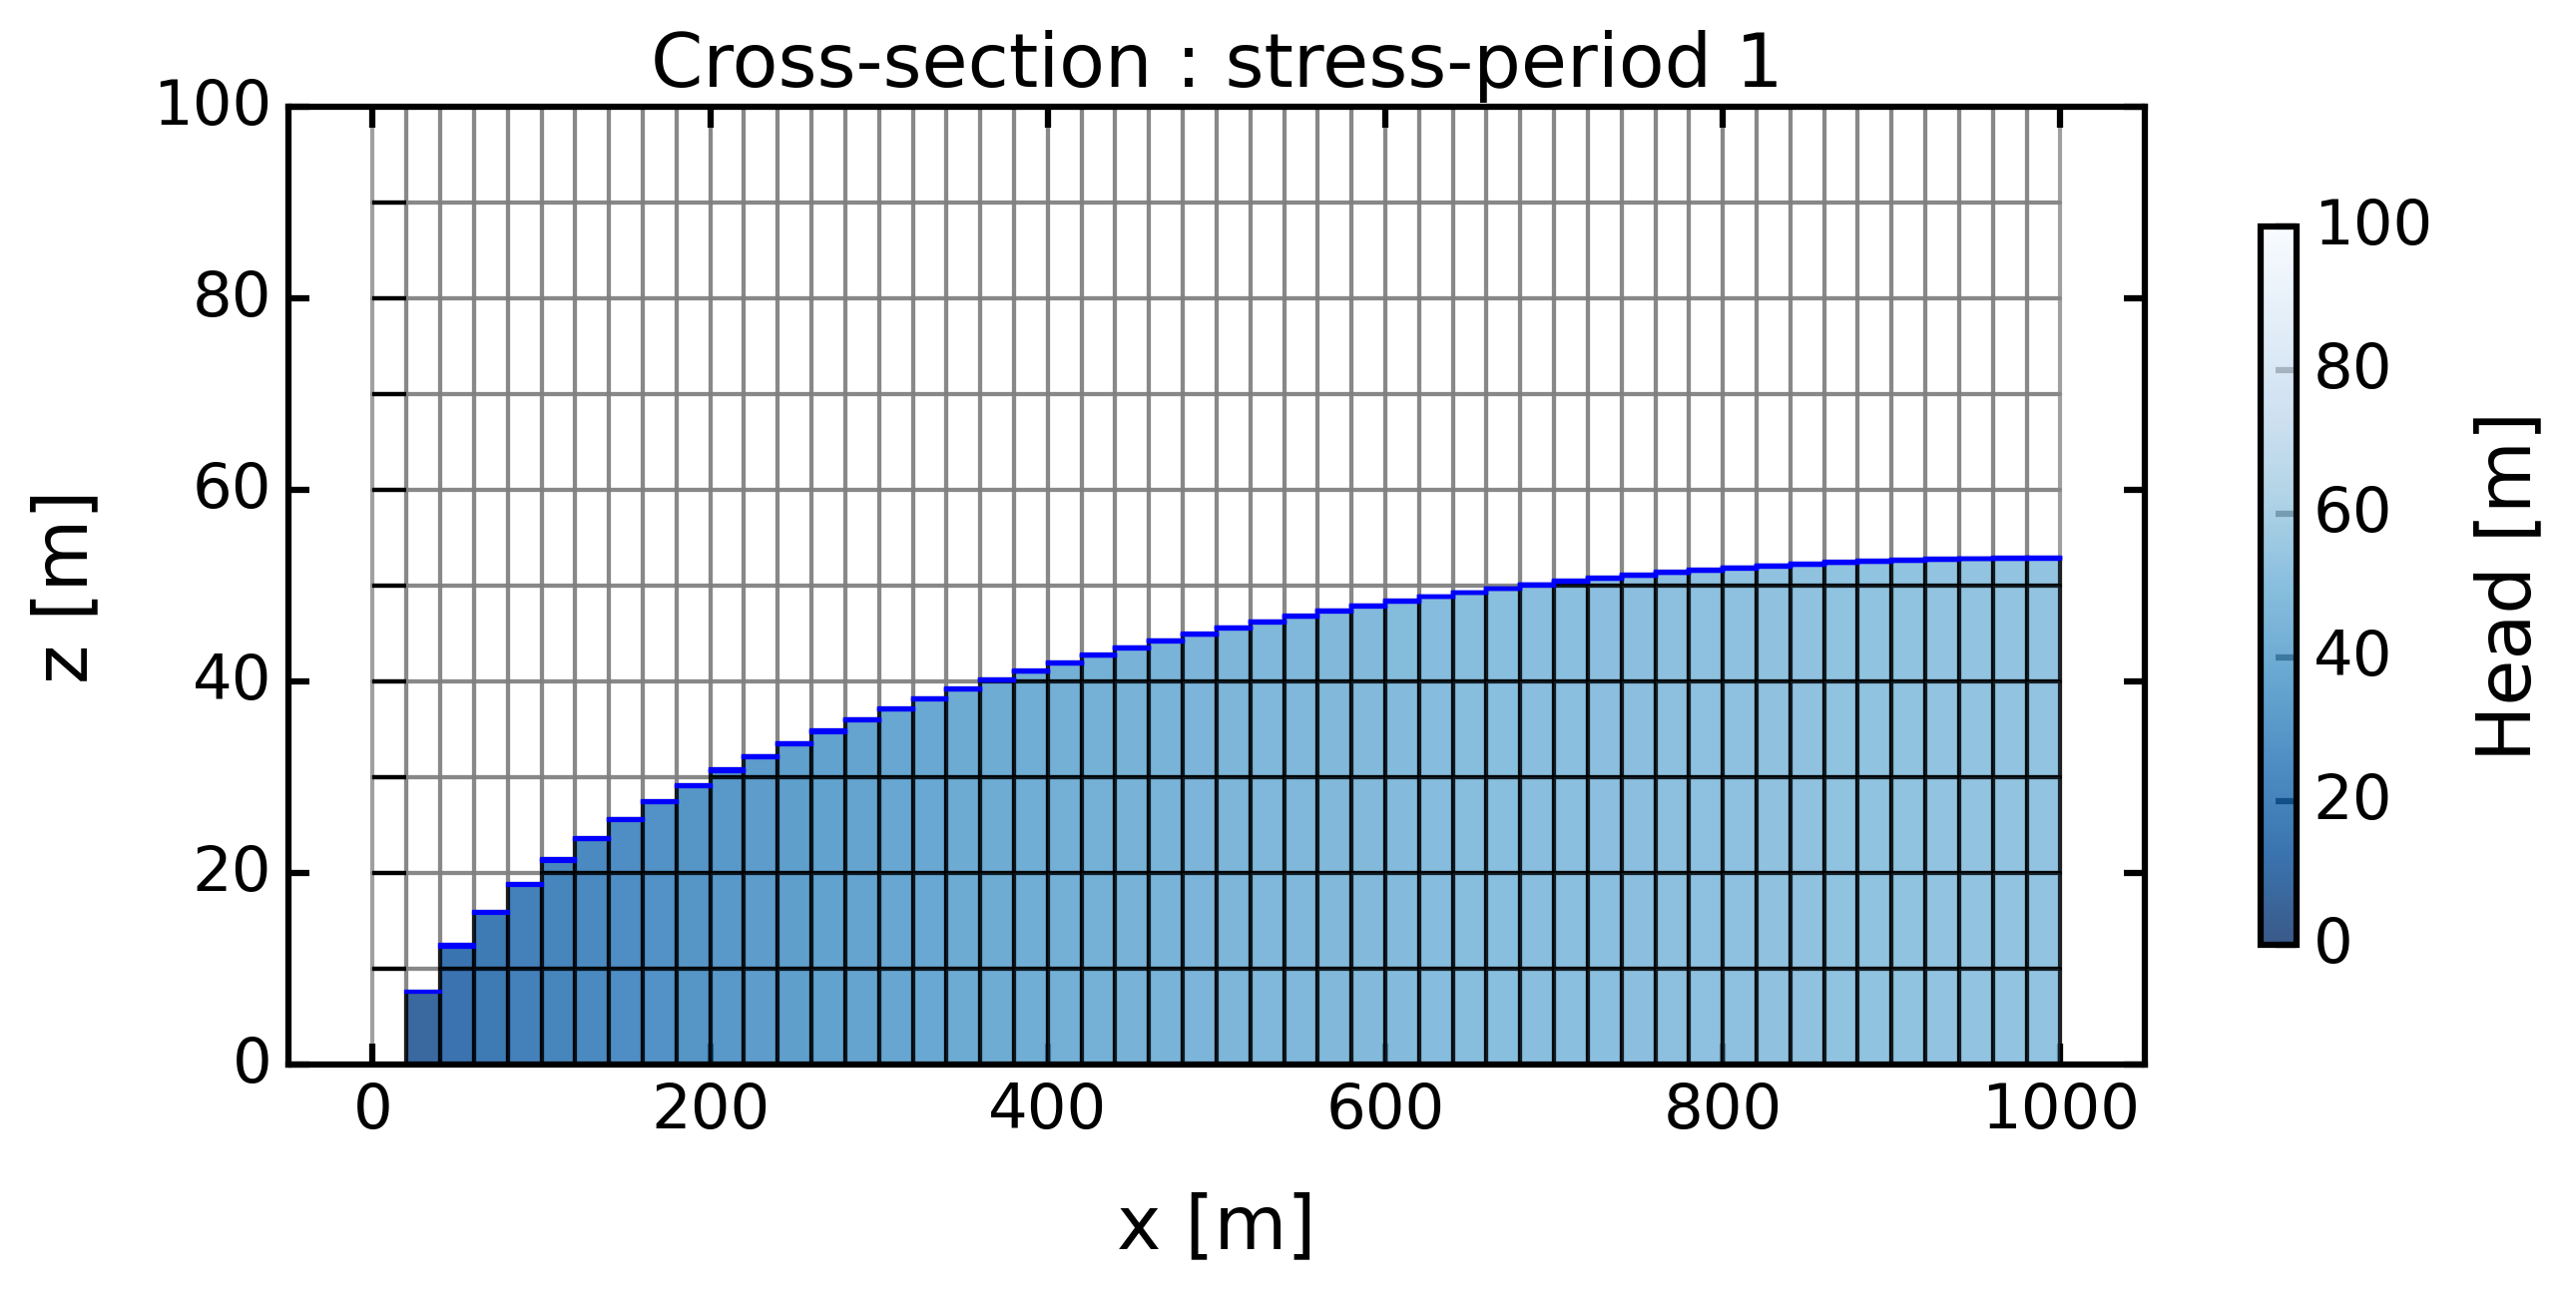

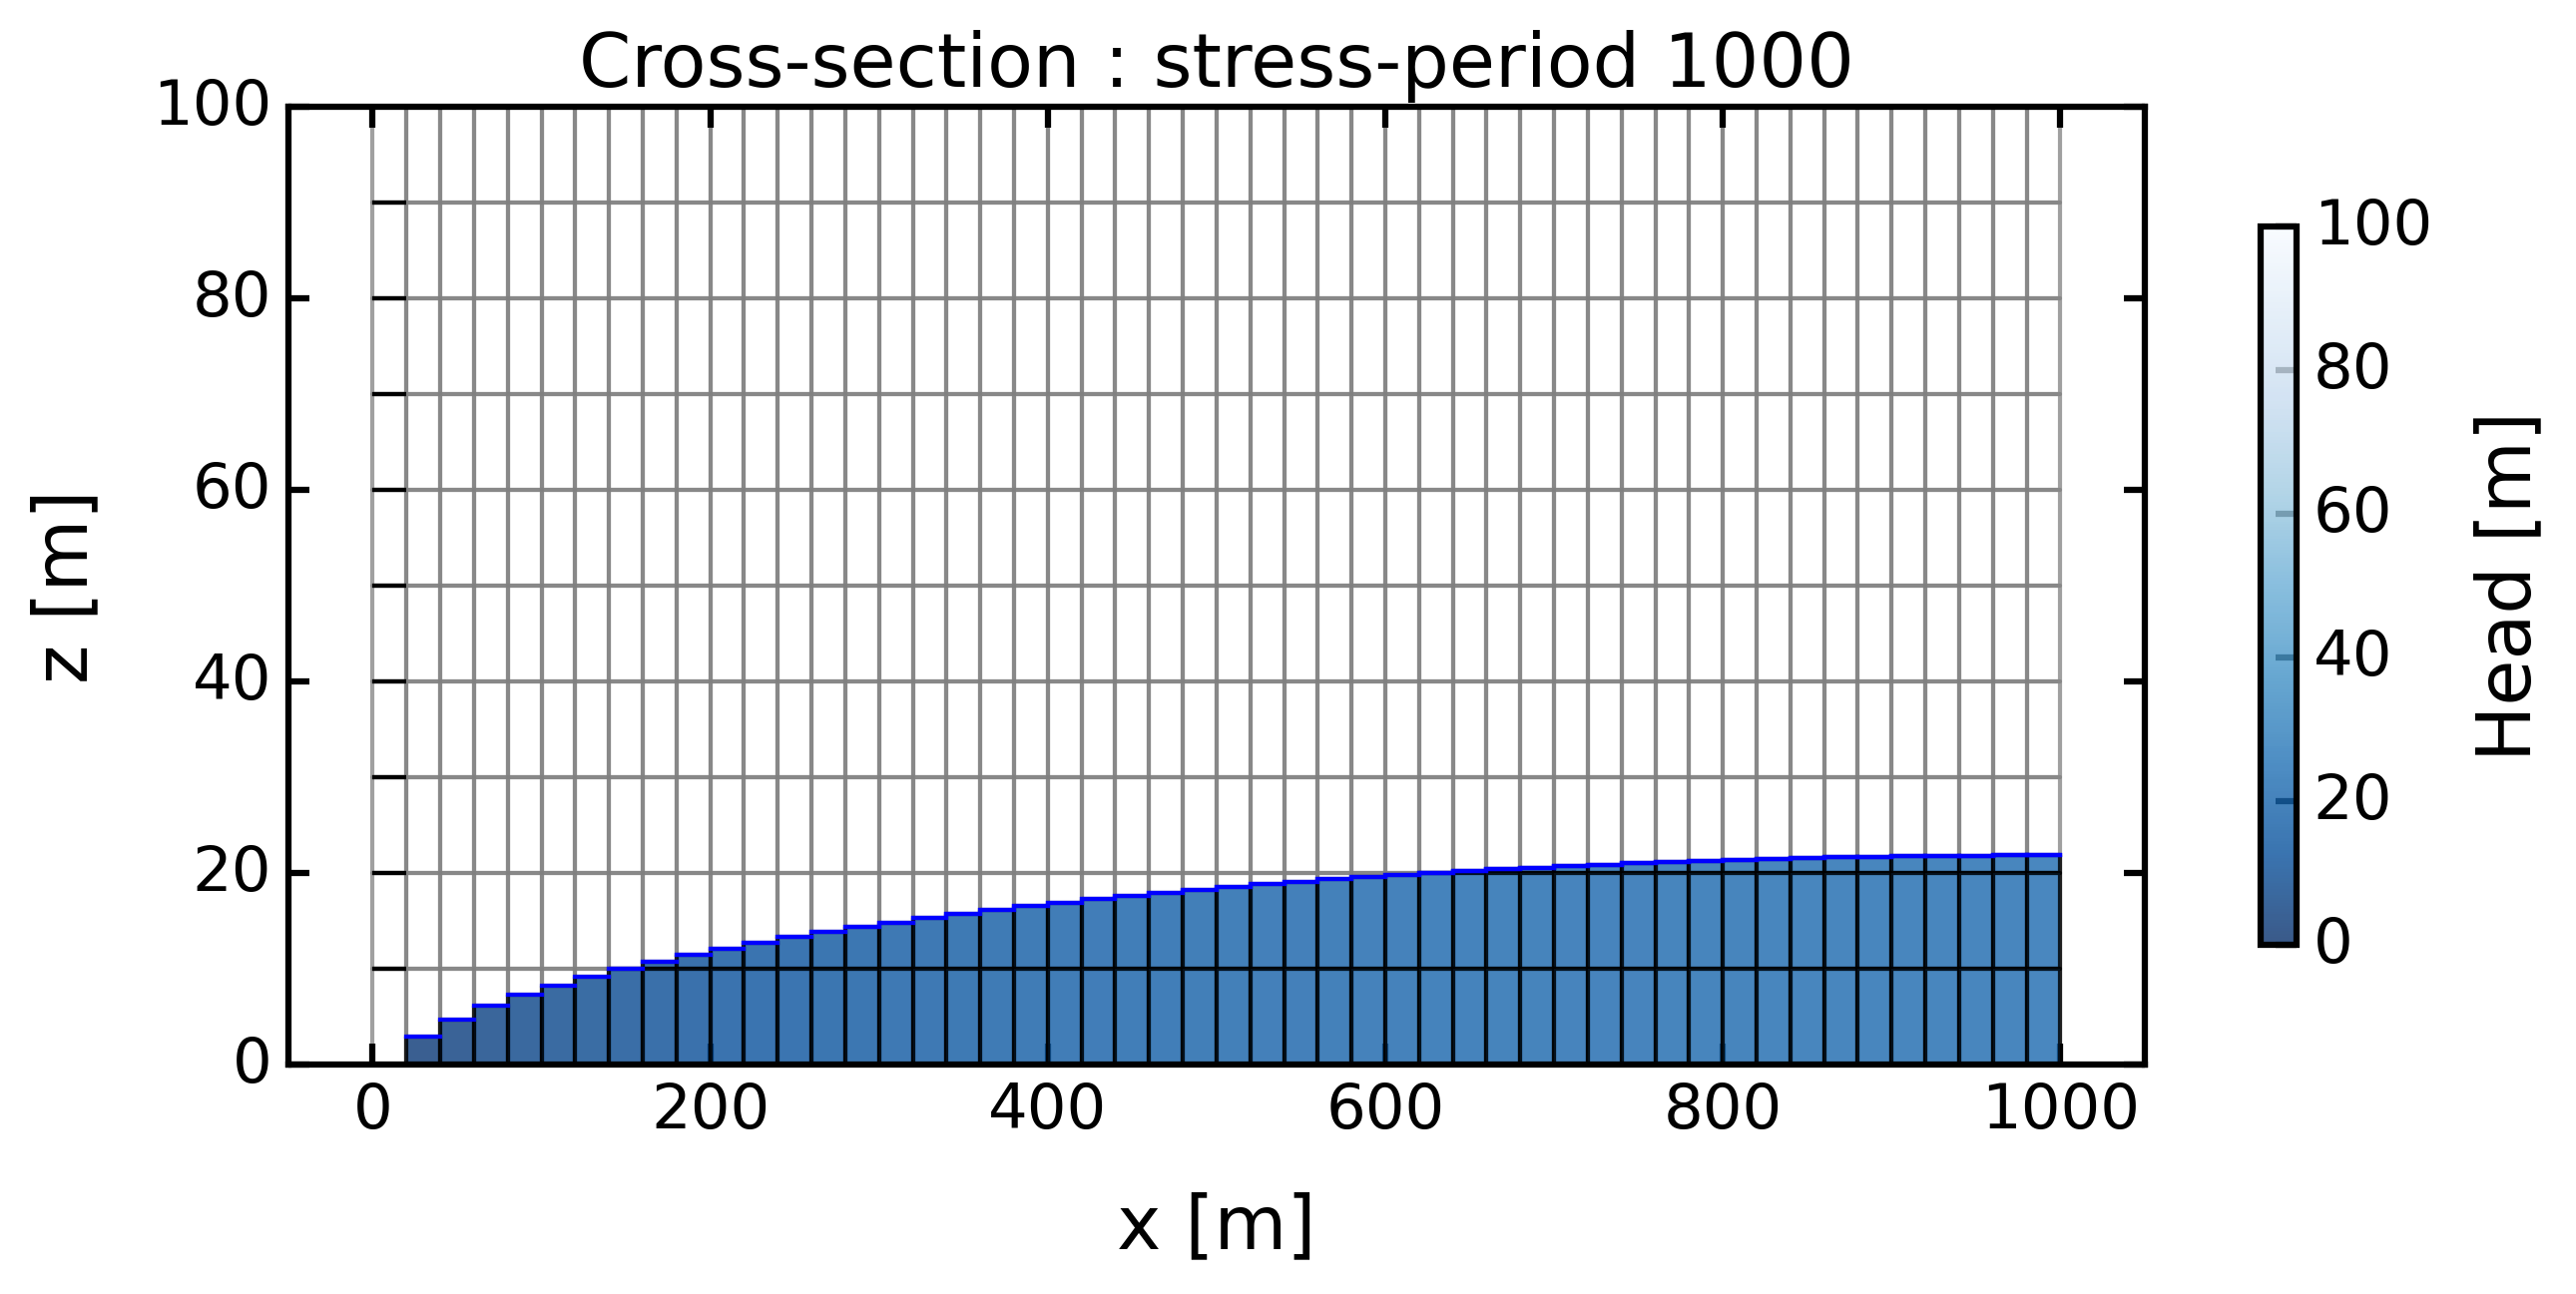

In [11]:

import flopy.utils.binaryfile as fpu

# Load model
fname = simulations_folder+model_name+'/'+model_name
ml = flopy.modflow.Modflow.load(fname+'.nam')
hdobj = flopy.utils.HeadFile(fname + '.hds')
times = hdobj.get_times()

# Plot first and last stress-period
for i, t in enumerate([times[0],times[-1]]):
    i = int(i)
    head = hdobj.get_data(totim=t)
    
    # Figure
    fig = plt.figure(figsize=(10, 4), dpi=300)
    ax = fig.add_subplot(1, 1, 1)
    ax.set_title('Cross-section : '+'stress-period '+str(int(t)))
    ax.set_xlabel('x [m]')
    ax.set_ylabel('z [m]')
    ax.set_ylim(0,100)

    xsect = flopy.plot.PlotCrossSection(model=ml, line={'Row': 0})
    
    # Head color
    pc = xsect.plot_array(head, masked_values=[999.], head=head, cmap='Blues_r',
                            vmin=0, vmax=100,
                          alpha=0.8)
    cb = plt.colorbar(pc, shrink=0.75)
    cb.set_label('Head [m]', labelpad=+10)
    wt = xsect.plot_surface(head, masked_values=[999.], color='b', lw=1)
    
    # Boundary
    patches = xsect.plot_ibound(head=head)
    
    # Grid
    linecollection = xsect.plot_grid(alpha=0.75, zorder=0)



In [12]:

fname = simulations_folder+model_name+'/'+model_name

cbb = fpu.CellBudgetFile(fname + '.cbc')
kstpkper = cbb.get_kstpkper()
# drain = cbb.get_data(text='DRAINS', kstpkper=kstpkper[0])
list_D = []
list_CH = []
list_R = []
list_S = []
for i in range(len(kstpkper)):   
    st = cbb.get_data(text='STORAGE', kstpkper=(0,i))
    ch = cbb.get_data(text='CONSTANT HEAD', kstpkper=(0,i))
    drain = cbb.get_data(text='DRAINS', kstpkper=(0,i))
    rec = cbb.get_data(text='RECHARGE', kstpkper=(0,i))
    list_D.append(drain[0]['q'].sum())
    list_CH.append(ch[0]['q'].sum())
    list_R.append(rec[0][-1][0].sum())    
    Qx = cbb.get_data(text='FLOW RIGHT FACE', kstpkper=(0,i))
    Qy = np.ones(shape=(10,1,100))
    Qz = cbb.get_data(text='FLOW LOWER FACE', kstpkper=(0,i))
    # Q = np.sqrt(Qx**2 + Qz**2) # 
    # Q_print = Q[0,0,0] # m/m

df = pd.DataFrame()
df = abs(pd.Series(list_CH).to_frame())
df.columns = ['Q']
df['Q'] = 2*df['Q'] / resamp_res # 2* because the formula is for 2 hillslopes, and we normalize by cell size
df['R'] = pd.Series(list_R)
df = df[30*3:]
df['t'] = np.arange(1,len(df)+1,1)
df['dQ'] = df['Q'].diff()
df['dt'] = df['t'].diff()
df['dQ/dt'] = abs(df['dQ'] / df['dt'])
# Formula: non-linear, late, b=3/2, Boussinesq (1904)
L = 1
A = 2*1000
df['a'] = ( 4.804*(hyd_cond**0.5)*L ) / ( porosity*((A)**1.5) )
b = 3/2
df['Bouss1904'] = df['a'] * (df['Q']**b)
# Paper: http://dx.doi.org/10.1029/2006WR005080; doi:10.102



Ratio difference: 0.996


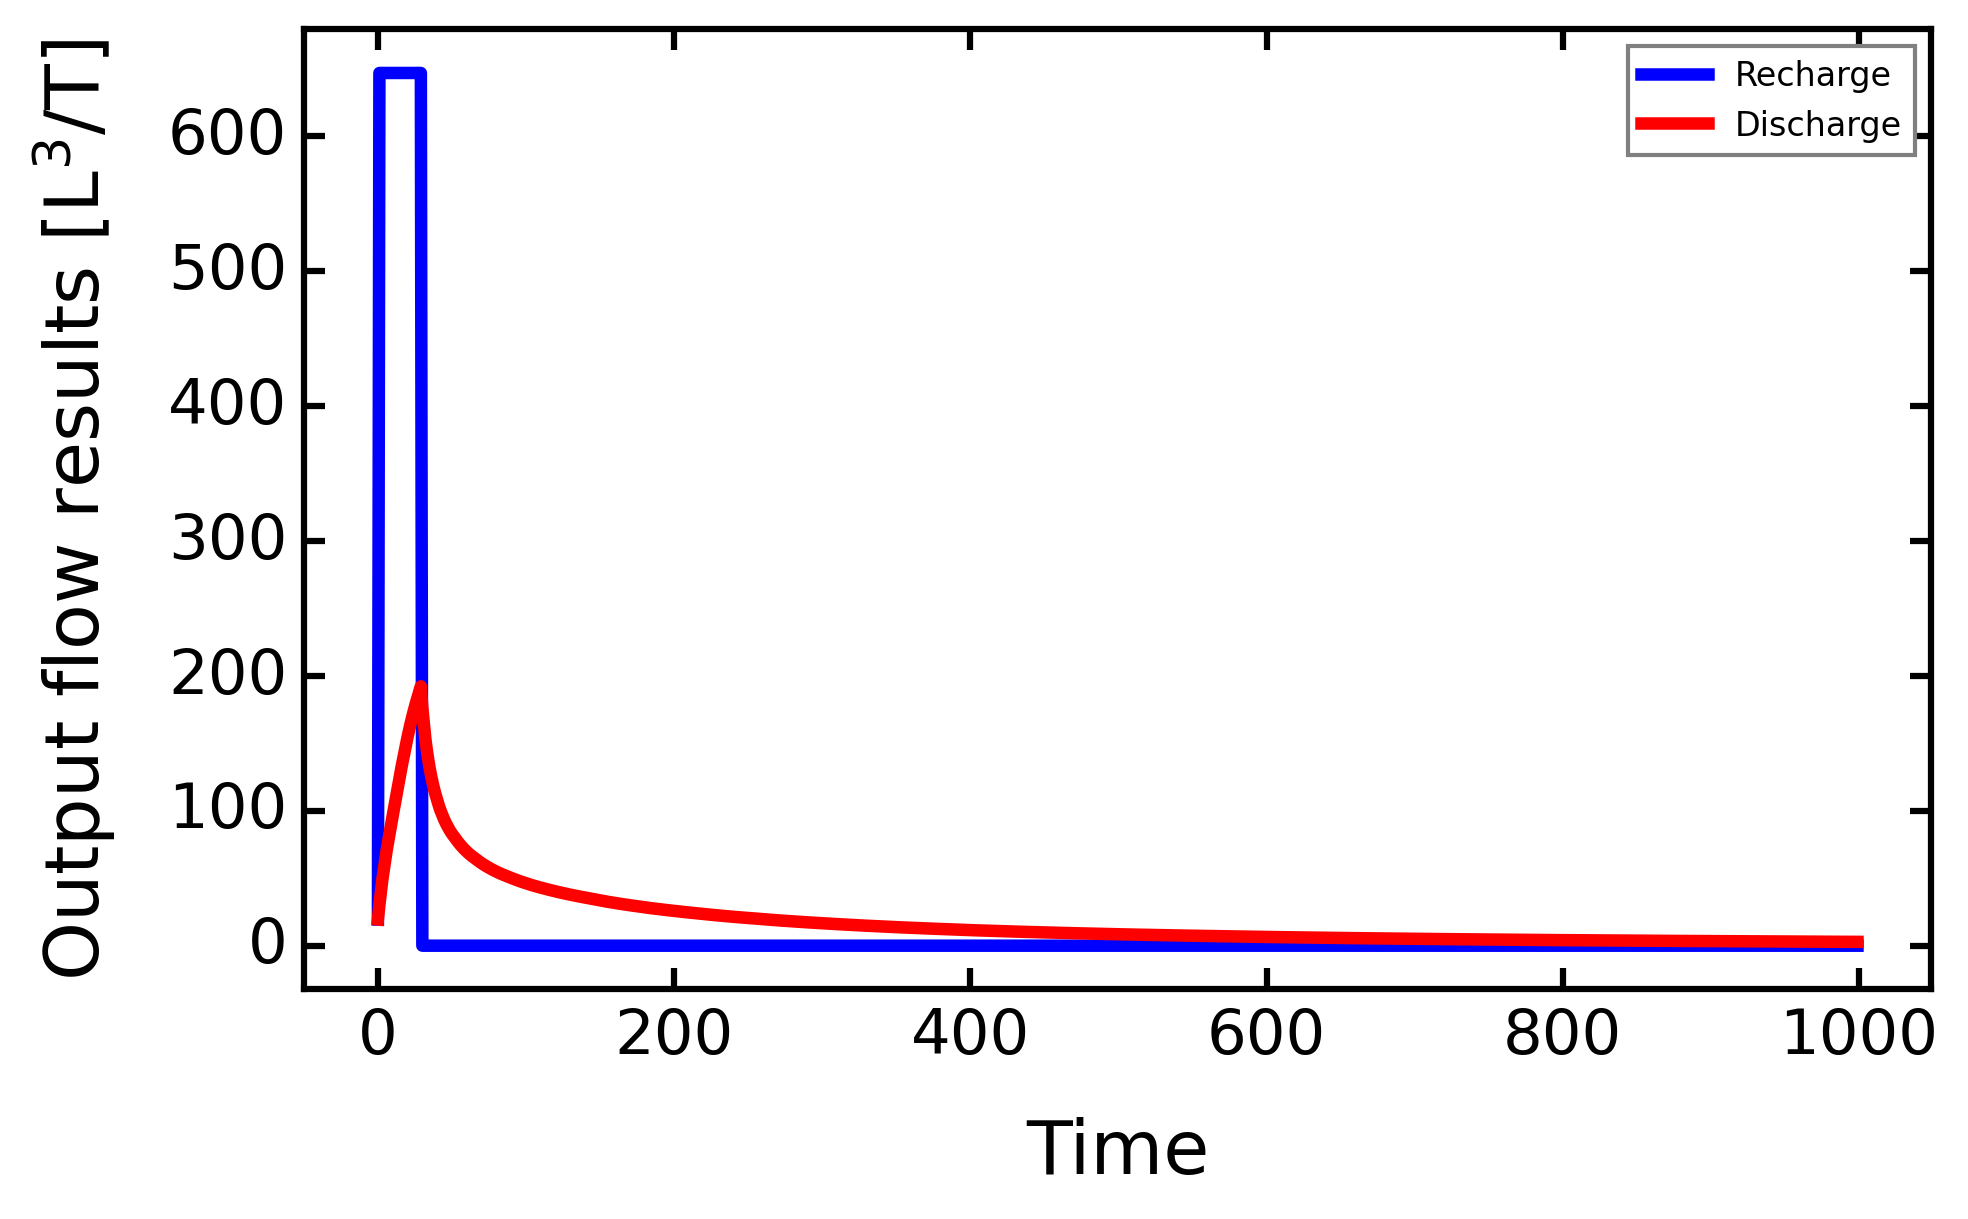

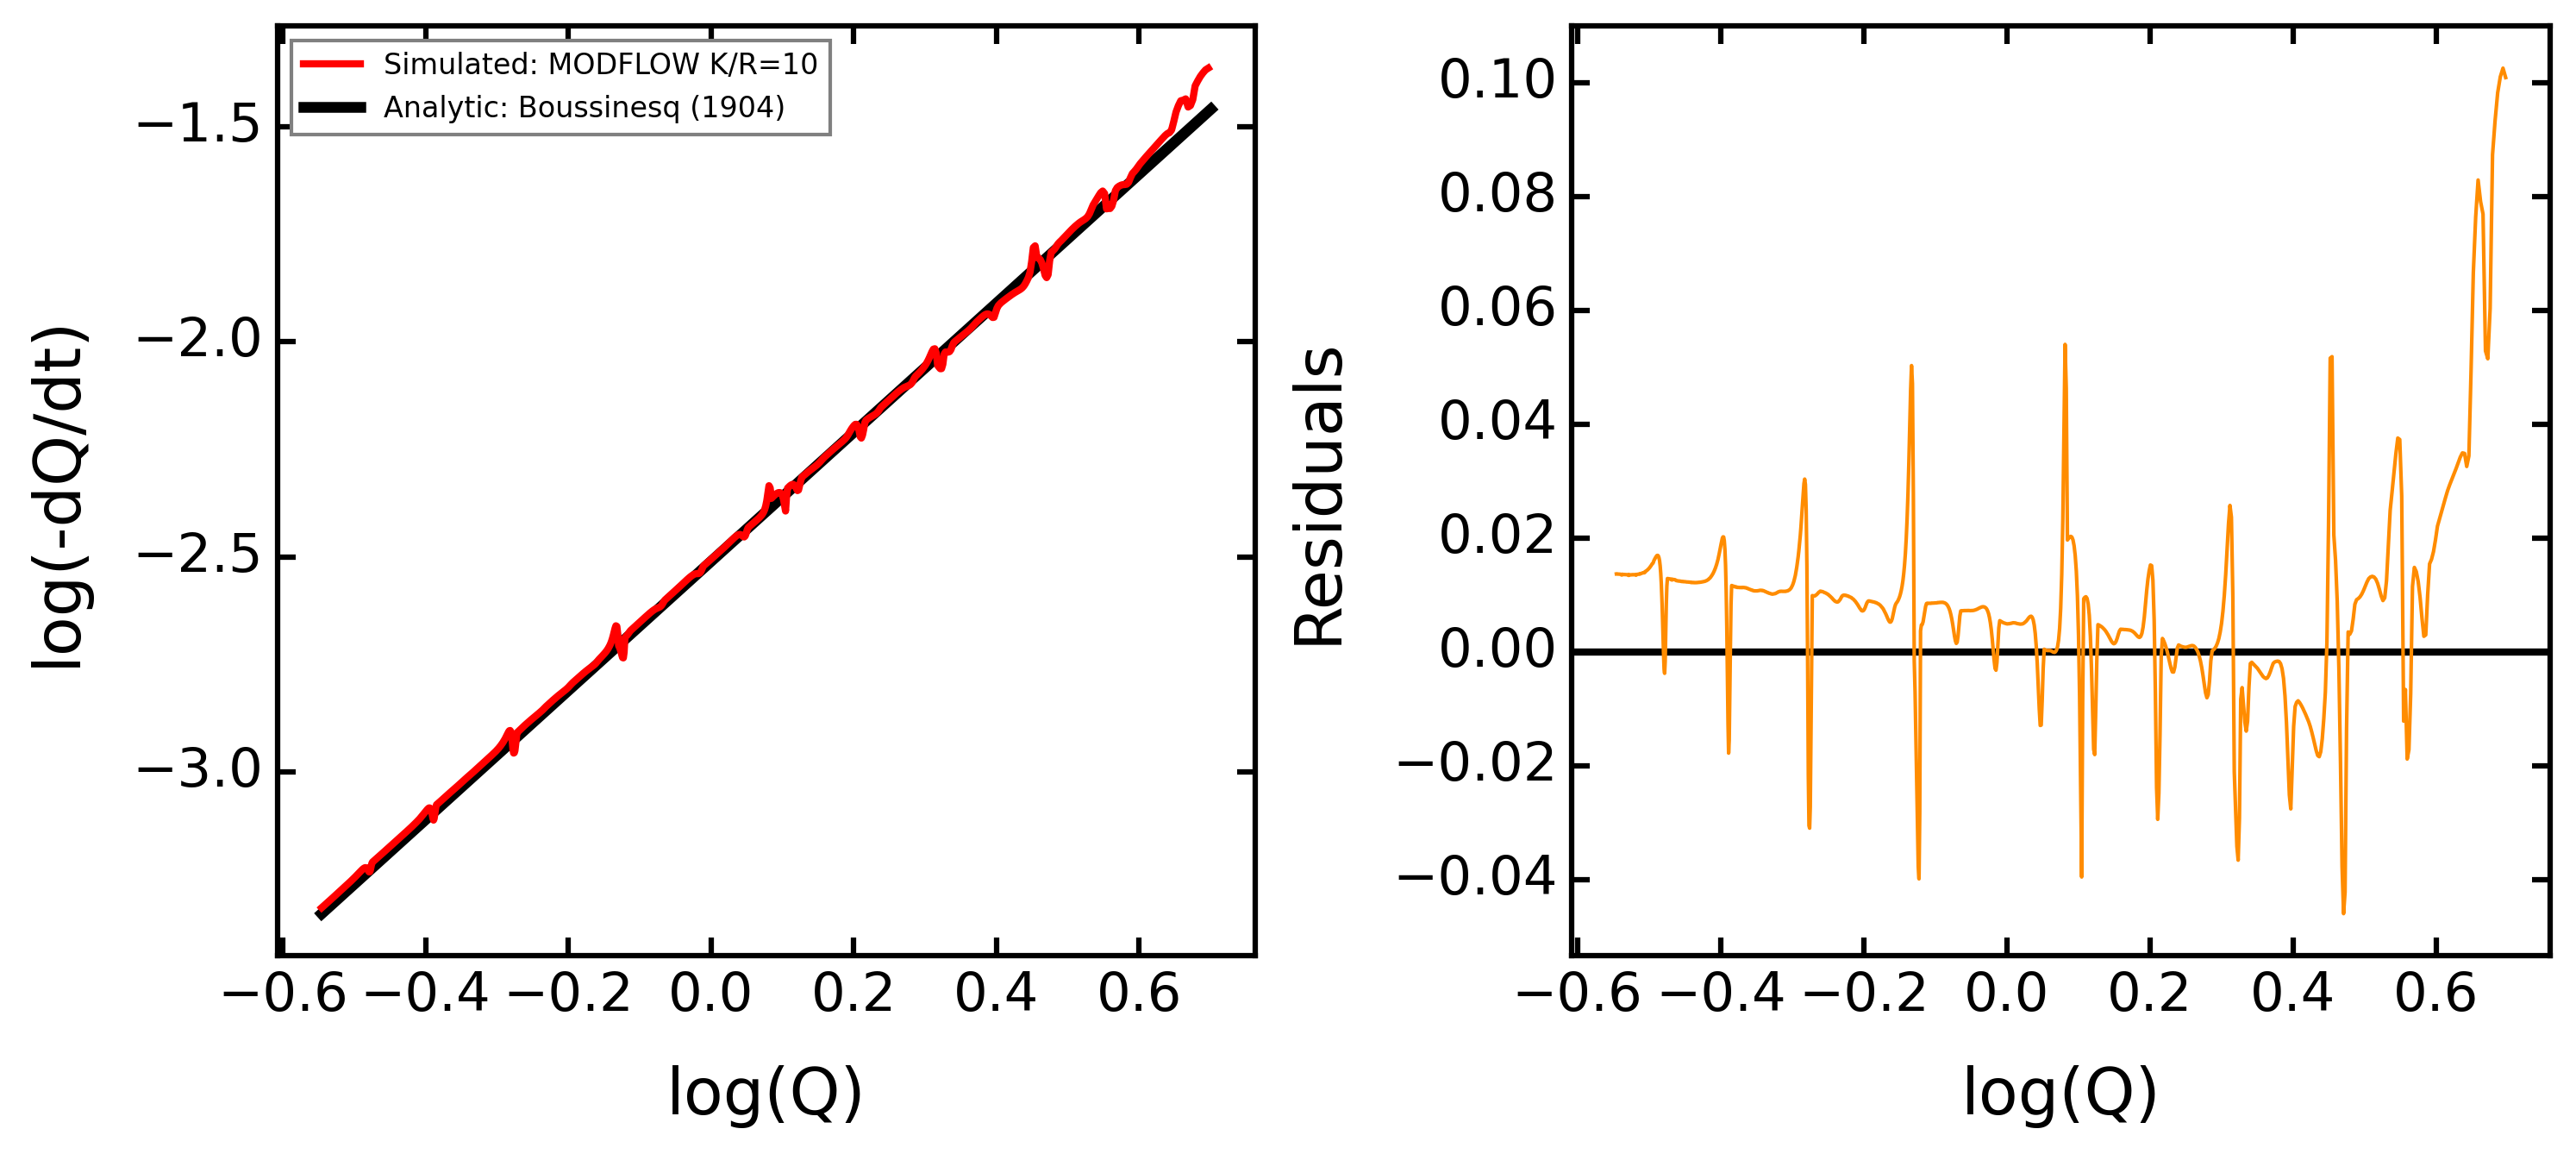

In [13]:

fig, ax = plt.subplots(figsize=(7, 4), dpi=300)
ax.plot(abs(pd.Series(list_R)), c='b', lw=3, label='Recharge')
ax.plot(abs(pd.Series(list_CH)), c='r', lw=3, label='Discharge')
ax.set_xlabel('Time')
ax.set_ylabel('Output flow results [$L^3$/T]')
ax.legend()

fig, axs = plt.subplots(1,2, figsize=(10, 4.5), dpi=300)
axs = axs.ravel()
ax = axs[0]
ax.plot(np.log10(df['Q']), np.log10(df['dQ/dt']), c='r', lw=2, label='Simulated: MODFLOW K/R='+str(KR))
ax.plot(np.log10(df['Q']), np.log10(df['Bouss1904']), c='k', lw=3, label='Analytic: Boussinesq (1904)', zorder=-1)
ax.set_xlabel('log(Q)')
ax.set_ylabel('log(-dQ/dt)')
ax.legend(loc='upper left')
ax = axs[1]
ax.plot(np.log10(df['Q']), np.log10(df['dQ/dt']) - np.log10(df['Bouss1904']), c='darkorange', zorder=1)
ax.set_xlabel('log(Q)')
ax.set_ylabel('Residuals')
ax.axhline(0, lw=2, zorder=-1, c='k')
fig.tight_layout()

fac = np.nanmean(np.log10(df['dQ/dt'])/np.log10(df['Bouss1904']))
print('Ratio difference:', round(fac,3))



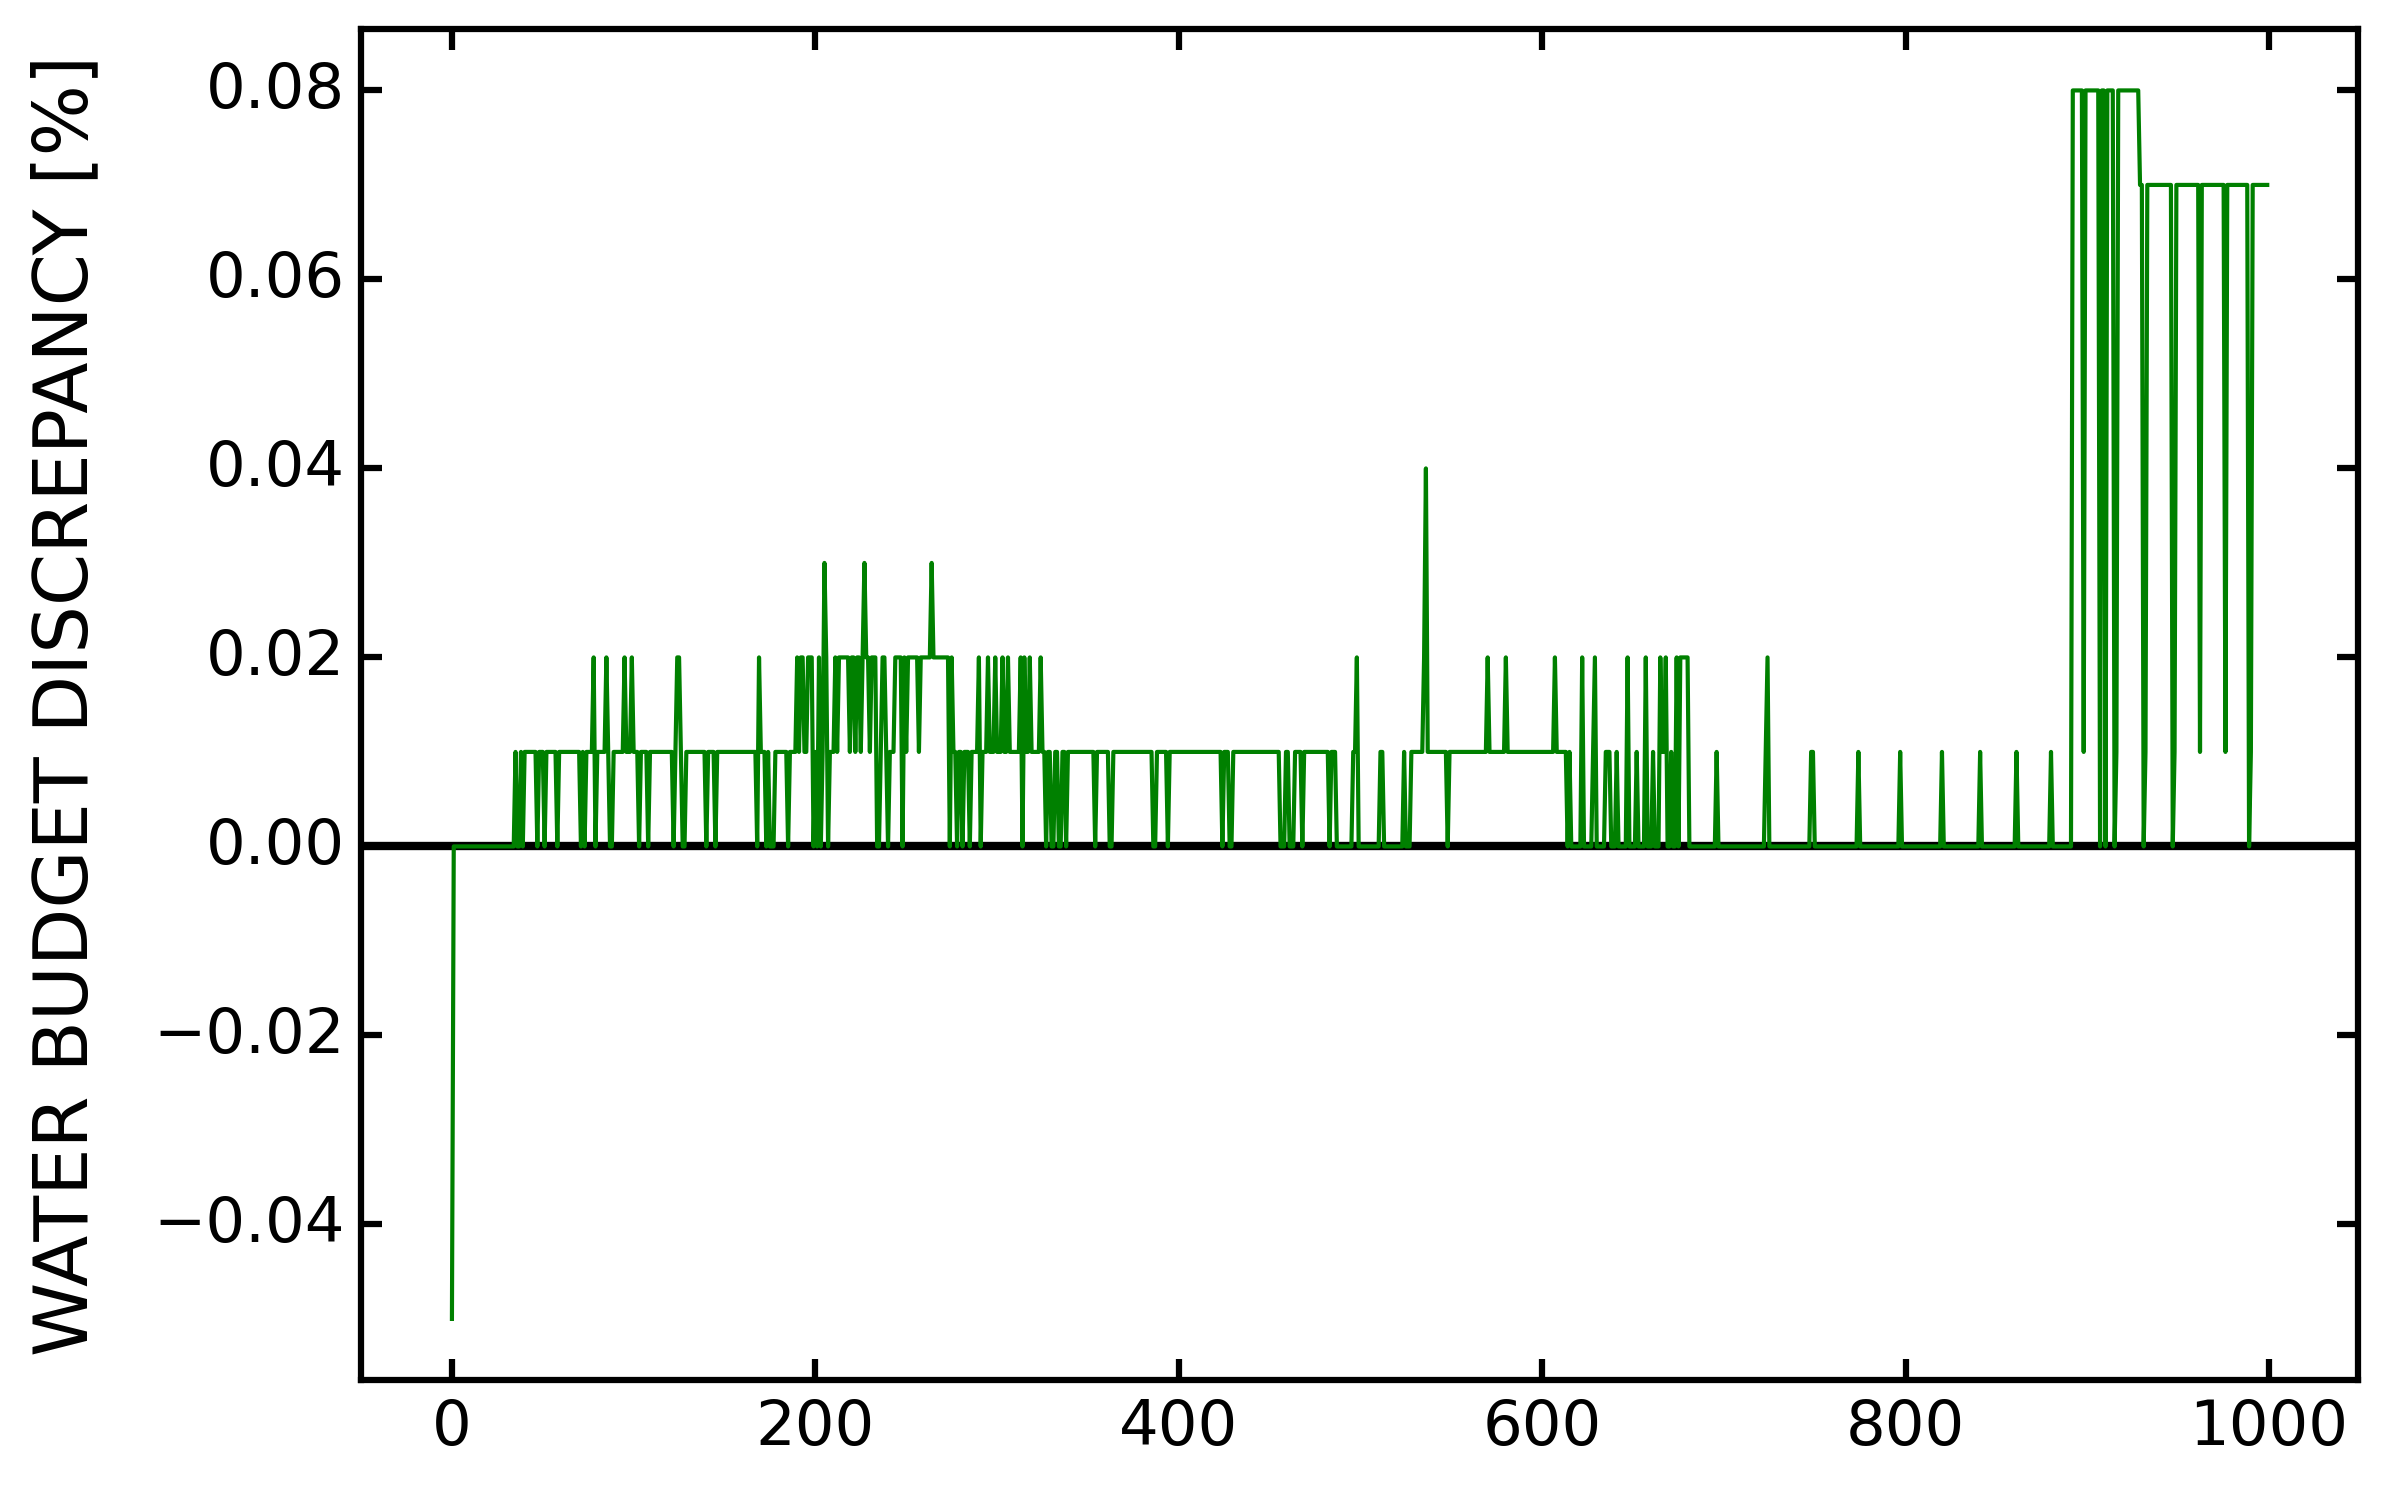

In [14]:

mf_list = flopy.utils.MfListBudget(simulations_folder+model_name+'/'+model_name+".list")
incremental, cumulative = mf_list.get_budget()
fig, ax = plt.subplots(figsize=(8, 5), dpi=300)
ax.plot(incremental['PERCENT_DISCREPANCY'], color='green')
ax.set_ylabel('WATER BUDGET DISCREPANCY [%]')
ax.axhline(0, lw=2, zorder=-1, c='k')
fig.tight_layout()



In [15]:

os.chdir(root_dir)

# wbt.verbose = True
# wbt.resample(
#     dem_path_ref, 
#     dem_path_res, 
#     cell_size=100, 
#     base=None, 
#     method="cc")
